# Pairs Trading Strategy Testing

In [2]:
#Import the necessary packages
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import statsmodels
from statsmodels.tsa.stattools import coint, adfuller
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

/Users/zescalan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
print(os.getcwd())
print(os.chdir('/Users/zescalan/Documents/code_files/PairsTrading'))
print(os.listdir())

/Users/zescalan/Desktop/zach/Zach-Escalante-Code/Yewno/Problem_3
None
['.DS_Store', 'BTC.csv', 'CVX.csv', 'CVX_1Y.csv', 'GOOG.csv', 'NFLX.csv', 'XOM.csv', 'XOM_1Y.csv']


#### Create an average ratio between our two assets (Netflix and Google in this case) 

In [4]:
Asset_1 = 'CVX.csv'
Asset_2 = 'XOM.csv'

In [5]:
asset_1 = pd.DataFrame.from_csv(Asset_1)
asset_2 = pd.DataFrame.from_csv(Asset_2)

In [6]:
print("Asset 1")
print(asset_1.head())
print("Asset 2")
print(asset_2.head())

Asset 1
                  Open        High         Low       Close  Adj Close   Volume
Date                                                                          
2013-04-12  120.459999  120.900002  119.500000  119.940002  98.548607  6391700
2013-04-15  118.809998  118.900002  116.500000  116.570000  95.779640  9766800
2013-04-16  117.339996  117.500000  116.209999  117.010002  96.141182  6511400
2013-04-17  116.400002  116.400002  114.120003  114.809998  94.333534  8291200
2013-04-18  114.879997  116.120003  114.599998  115.589996  94.974426  6451600
Asset 2
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2013-04-12  88.879997  89.190002  88.410004  88.989998  75.492004  11505100
2013-04-15  88.290001  88.669998  86.269997  86.489998  73.371223  19626200
2013-04-16  87.190002  87.230003  86.089996  86.610001  73.473030  14578800
2013-04-17  86.209999  86.379997  85.019997  86.080

In [7]:
df_ts = pd.merge(asset_1[['Close']], asset_2[['Close']], how='inner', left_index=True, right_index=True, sort=True, suffixes=('_Y', '_X'))

#### Plot the prices of the assets to see if they appear they could be co-integrated

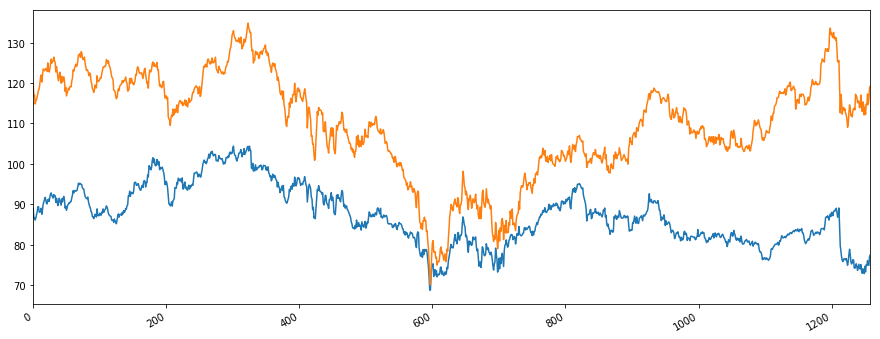

In [8]:
plt.figure()
df_ts['Close_X'].plot(use_index = False, label = 'Close_X')
df_ts['Close_Y'].plot(use_index = False, label = 'Close_Y')

#### Let's graph the ratios of these time series to deteremine if co-integration exists

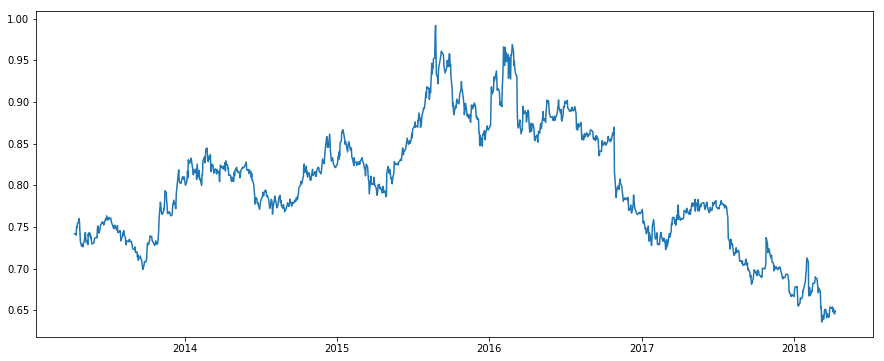

In [9]:
plt.plot(df_ts['Close_X']/df_ts['Close_Y'])

#### Evaluating the Statistical Significance of the Spread

While it's helpful to look at the graphs of two assets to examine for visible sings of co-integration, we need a more concrete statistical test. One way of doing this is to convert the ratios to Z-scores

In [10]:
series_ratio = df_ts['Close_Y']/df_ts['Close_X']

Write a function to compute the Z-scores of the series rations

In [11]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

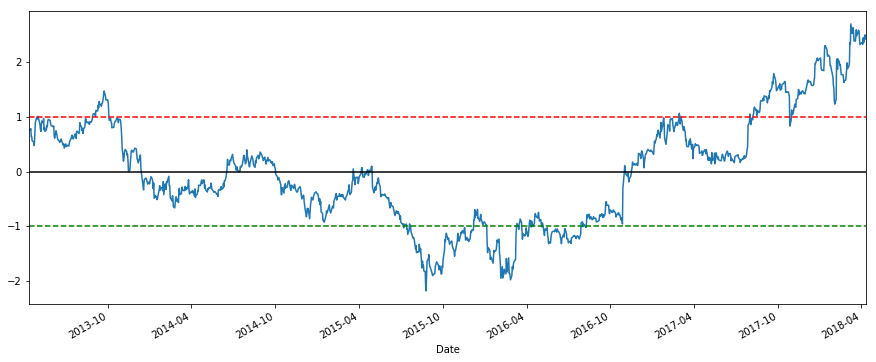

In [12]:
zscore(series_ratio).plot()
plt.axhline(zscore(series_ratio).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

#### Pairs Trading Strategy

A simple strategy based on this time series (not one that I would recommend except for illustration purposes) would be to go long the spread when the Z-Score < -1 and short the spread when the Z-score > 1.

To provide some statistical basis for these decisions, let's discuss the difference between **co-integration** and **correlation**. 

**cointegration** is when two variables which follow a random walk have a linear combination which is **stationary**
**correlation** measures how strong a relationship is between two variables

These are very simple definitions, but for our purposes **cointegration** is more useful to us for detecting pairs trading strategies than **correlation**

We evaluate this hypothese with two different test: **Engle-Granger** and **Dickey Fuller**

The **Engle-Granger** test uses the **coint** function in the **statsmodels** package in Python to evaluate whether two series are cointegrated. The null hypothesis is that **no cointegration** exists, so a low p-value indicates that two series are cointegrated whereas a high p-value indicates that we fail to reject the null hypothesis of no cointegration.

In [13]:
score, pvalue, _ = coint(df_ts['Close_Y'], df_ts['Close_X'])
print('Engle-Granger two-step cointegration test')
print("Score: ", score)
print("P-Value: ", pvalue)

Engle-Granger two-step cointegration test
Score:  -0.824955775902
P-Value:  0.931344408911


The null hypothesis of the **Augmented Dickey-Fuller** is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The presence of a unit root means that the beta co-efficient in an AR(1) model is >1, hence the series do not co-integrate (revert to a stable mean, or are **stationary**). 

In [14]:
#The augmented Dickey–Fuller (ADF) statistic, used in the test, is a negative number. 
#The more negative it is, the stronger the rejection of the hypothesis that there is 
#a unit root at some level of confidence

adf = adfuller(df_ts['Close_Y'] - df_ts['Close_X'])
print('Augmented Dickey Fuller Test')
print("ADF Score: ", adf[0])
print("P-Value: ", adf[1])

Augmented Dickey Fuller Test
ADF Score:  -1.11360508376
P-Value:  0.709615971834


#### These assets do NOT demonstrate statistical values sufficient for implementing a pairs trading strategy - but since the purpose of this Jupyter Notebook is demonstrative as opposed to alpha extraction, we will continue with showing how such a strategy could be implemented.

#### Updating Statistics: Moving Averages

It is highly impractical in real life that the ratios between two assets will always be cointegrated. In order to test different levels of co-integration, we need to calculate **moving averages**. Fortunately for us, the **pandas** package in Python has a **rolling_mean** method that allows us to calculate averages for different numbers of time periods by simply adjusting the tuning parameters.

In [15]:
difference = df_ts['Close_X'] - df_ts['Close_Y']

In [16]:
# Get the 30 day moving average of the difference
moving_avg10 = pd.rolling_mean(difference, window=10)
moving_avg10.name = '10 day moving avererage'

#Get the 60 day moving average of the difference
moving_avg60 = pd.rolling_mean(difference, window=60)
moving_avg60.name = '60 day moving avererage'

#Get the 90 day moving average of the difference
moving_avg90 = pd.rolling_mean(difference, window=90)
moving_avg90.name = '90 day moving avererage'

#Get the 180 day moving average of the difference
moving_avg180 = pd.rolling_mean(difference, window=180)
moving_avg180.name = '180 day moving avererage'

/Users/zescalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  
/Users/zescalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  
/Users/zescalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
  # Remove the CWD from sys.path while we load stuff.
/Users/zescalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=180,center=Fal

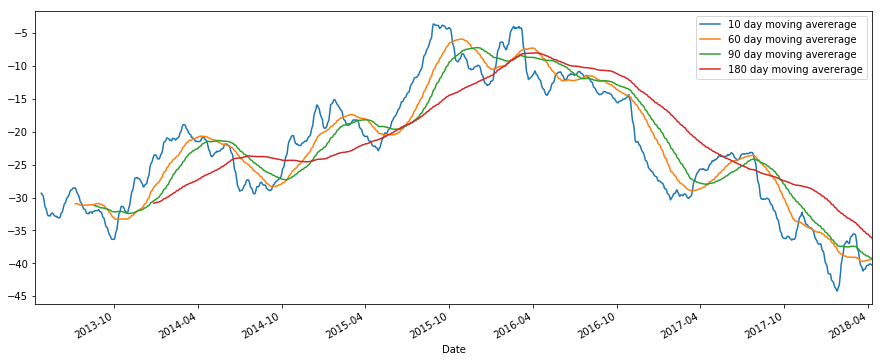

In [18]:
pd.concat([moving_avg10, moving_avg60, moving_avg90, moving_avg180], axis=1).plot()

#### Using Moving Average Differences

Using the differences between moving averages (say 10 day and 180 day moving average) can help to give us a clearer picture as to whether the recent prices are showing trends of mean reversion. We demonstrate one such example below:

/Users/zescalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=180,center=False).std()
  


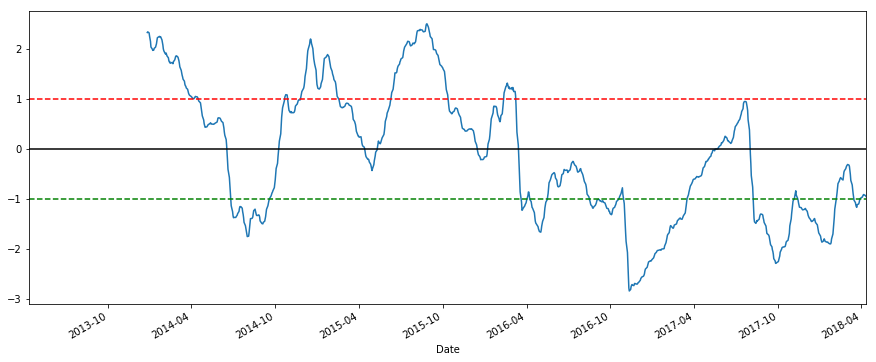

In [19]:
# Take a rolling 180 day standard deviation
sd_180 = pd.rolling_std(difference, window=180)
sd_180.name = '180 Day Std Dev'

# Now compute Z-Scores for each day
zscore_180_10 = (moving_avg10 - moving_avg180)/sd_180
zscore_180_10.name = 'z-score'
zscore_180_10.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')

#### How much should I buy/sell of each asset?

A rule of thumb that I've read in various papers is to take the ratio of one asset to the other. **For example, if the 30-day Moving Average ratio of Stock X over Stock Y is 1.5, then for every three shares of Stock X that I buy/sell, I sell/buy 2 shares of stock Y**

/Users/zescalan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  """Entry point for launching an IPython kernel.


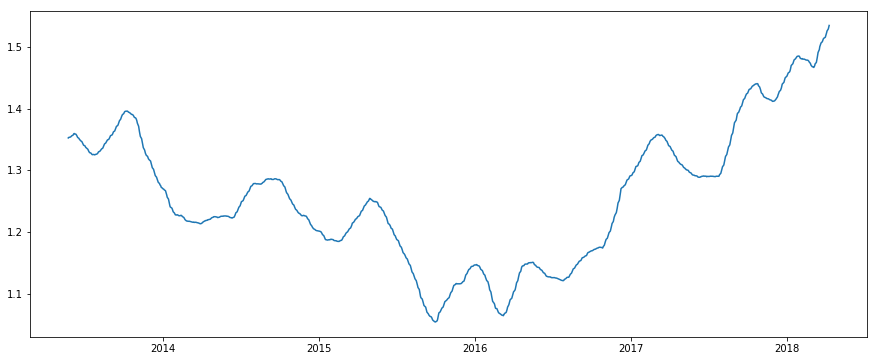

In [20]:
plt.plot(pd.rolling_mean(df_ts['Close_Y'], window = 30)/pd.rolling_mean(df_ts['Close_X'], window = 30))

#### Summary

Implementing a successful pairs trading strategy is a labor intensive pursuit - far beyond what we can do with simple example data sets. The last thing that I would implement if this was a real live pairs trading strategy would be a **Training/Testing Split**. As in any machine learning model, we would need to split up our data sets in training/test splits so that we can test how successful our strategy would have been if it had been implemented over a specified period of time.
